In [32]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
src = "/home/andres/data/hbmep-processed/J_SHAP/data.csv"
df = pd.read_csv(src)

In [6]:
df.columns

Index(['pulse_amplitude', 'pulse_train_frequency', 'pulse_period',
       'pulse_duration', 'pulse_count', 'train_delay', 'channel1_1',
       'channel1_2', 'channel1_3', 'channel1_4', 'channel2_1', 'channel2_2',
       'channel2_3', 'channel2_4', 'charge_params_1', 'charge_params_2',
       'charge_params_3', 'charge_params_4', 'bank_check', 'run', 'enabled',
       'channel_failA', 'channel_failB', 'channel_fail_comb', 'time_pulse',
       'time', 'ix_onsets', 'auc_2', 'auc_6', 'auc_5', 'auc_7', 'auc_1',
       'auc_4', 'auc_3', 'auc_8', 'channel1_laterality', 'channel1_segment',
       'channel2_laterality', 'channel2_segment', 'compound_position',
       'compound_charge_params', 'participant', 'subdir_pattern',
       'charge_param_error'],
      dtype='object')

In [5]:
file = open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl","rb")
combo = pickle.load(file)

In [35]:
def threshold_array(shape):
    my_dict = {
    (key[0], key[1], key[3]): value["a"].mean() for  key,value in combo.items() if key[2] == shape
    }
    keys, values = zip(*my_dict.items())
    axis0 = np.unique([key[0] for key in keys])
    axis1 = ["Deltoid", "Biceps", "Triceps", "ECR", "FCR", "ADM"][::-1]
    pos_L = np.zeros((len(axis0), len(axis1)))
    pos_M = np.zeros((len(axis0), len(axis1)))
    for key, value in zip(keys, values):
        if key[1].split("-")[0][2:] == "L":
            pos_L[np.where(axis0 == key[0])[0], np.where(np.array(axis1) == key[2][1:])[0]] = 1/value 
        elif key[1].split("-")[0][2:] == "M":
            pos_M[np.where(axis0 == key[0])[0], np.where(np.array(axis1) == key[2][1:])[0]] = 1/value 
    return(pos_L, pos_M, axis0, axis1)

In [30]:
L, M = threshold_array("20-0-80-25")

In [31]:
ttest_values, pscores = stats.ttest_ind(L, M)
pscores


array([0.92528306, 0.38606512, 0.67930961, 0.50053072, 0.51280737,
       0.35147554])

Graphing if we want group comparison

In [70]:
def graph_arr(charge):
    L, M, subject, muscle = threshold_array(charge)
    sub_meanS = np.median(L, axis=0)
    rowS = np.vsplit(L,len(subject))
    rowS = [i.tolist() for i in rowS]
    sub_meanL = np.median(M, axis=0)
    rowL = np.vsplit(M,len(subject))
    rowL = [i.tolist() for i in rowL]
    for xval_ind, xval in enumerate(rowS):
        # plt.plot(xval[0], muscle, linestyle='dashed', marker=".", markersize=20, alpha =0.3, color = "pink")
        plt.plot(sub_meanS,muscle, color = "red", linestyle='dashed', marker=".", markersize=20, label="Lateral" if xval_ind == 0 else None)
        # plt.legend('Lateral')
    for xval_ind,xval in enumerate(rowL):
        # plt.plot(xval[0], muscle, linestyle='dashed', marker=".", markersize=25, alpha =0.3, color = "blue")
        plt.plot(sub_meanL,muscle, color = "black", linestyle='dashed', marker=".", markersize=20, label="Medial" if xval_ind == 1 else None)
        # plt.legend('Medial')
    plt.yticks(weight ='bold',style = 'italic')
    plt.xlabel('Efficacy')
    plt.legend()
    plt.show()
    

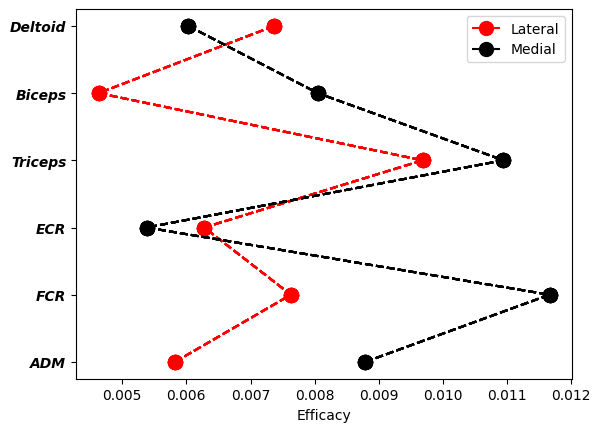

In [71]:
graph_arr("20-0-80-25")